Code: ke_corrections

Purpose: To calculate the K and E corrections for the BGS data, based
on Alex Smith's code.

In [1]:
import  numpy                   as      np
import  astropy
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
from    astropy.table           import  Table, join, vstack, unique, setdiff
from    astropy.coordinates     import  SkyCoord, match_coordinates_sky
from    astropy                 import  units as u
from    astropy.io              import  ascii
from    scipy                   import  optimize
from    scipy.integrate         import  quad
from    scipy.optimize          import  curve_fit
from    scipy.interpolate       import  interp1d, RegularGridInterpolator
from    scipy                   import  stats
from    tqdm                          import tqdm
import  scipy
#import desiutil.dust

In [2]:
from    astropy.cosmology       import  FlatLambdaCDM
# setting cosmological parameters
h = 1
cosmo = FlatLambdaCDM(H0=100*h * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0= 0.25) #0.3)

In [3]:
mag_limit = 19.8
z_shift = False

In [5]:
def colour_observer(colour_rest, z):
    '''
    Returns the observer-frame colour for some rest-frame colour and z.

    Input: colour_rest = the rest-frame g-r colour of the galaxy.  [int, float, array]
           z = the redshift of the galaxy.                         [int, float, array]
    '''
    
    if isinstance(colour_rest, int) or isinstance(colour_rest, float):
        colour_rest = np.array([colour_rest])
    else:
        colour_rest = np.array(colour_rest)
    
    if isinstance(z, int) or isinstance(z, float):
        z = np.array([z])
    else:
        z = np.array(z)
    
    '''
    this try is due to a weird edge case (with single numpy type)
    '''
    try:
        if len(z) == 1 and len(colour_rest) == 1:
            k_r = gama_kcorr_r.k(z, colour_rest)
            k_g = gama_kcorr_g.k(z, colour_rest)

        else:        
            k_r = []
            k_g = []
            for i in range(len(colour_rest)):
                k_r.extend(gama_kcorr_r.k(np.array([z[i]]), np.array([colour_rest[i]])))
                k_g.extend(gama_kcorr_g.k(np.array([z[i]]), np.array([colour_rest[i]])))

            k_r = np.array(k_r)
            k_g = np.array(k_g)

    except:
        z = np.array([z])
        if len(z) == 1 and len(colour_rest) == 1:
            k_r = gama_kcorr_r.k(z, colour_rest)
            k_g = gama_kcorr_g.k(z, colour_rest)

        else:        
            k_r = []
            k_g = []
            for i in range(len(colour_rest)):
                k_r.extend(gama_kcorr_r.k(np.array([z[i]]), np.array([colour_rest[i]])))
                k_g.extend(gama_kcorr_g.k(np.array([z[i]]), np.array([colour_rest[i]])))

            k_r = np.array(k_r)
            k_g = np.array(k_g)

    return colour_rest + k_g - k_r 


def colour_func(colour_rest, colour_obs, z):
    '''
    Returns the difference between the apparent magnitude from the function and the 
    actual observer-frame colour.
    '''
    colour_rest = np.array([colour_rest])
    colour_observer_func = colour_observer(colour_rest, z)
    return colour_observer_func - colour_obs


def colour_rest_func(colour_obs, z):
    '''
    Returns rest-frame colour values using Brent's method.
    '''
    root = optimize.brentq(colour_func, -10000, 10000, args=(colour_obs, z))
    return root


def K_corr(z, colour_obs, params):
    if params == None:
        
        z = np.array([z])
        colour_obs = np.array([colour_obs])
        colour_rest = colour_rest_func(colour_obs, z)
        colour_rest = np.array([colour_rest])
        
        k_r = gama_kcorr_r.k(z, colour_rest)
        k_g = gama_kcorr_g.k(z, colour_rest)
        
        return k_r
    
    else:
        return params[0]*z**4 + params[1]*z**3 + params[2]*z**2 + params[3]*z**1 + params[4]*z**0 

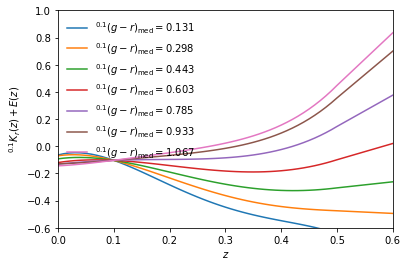

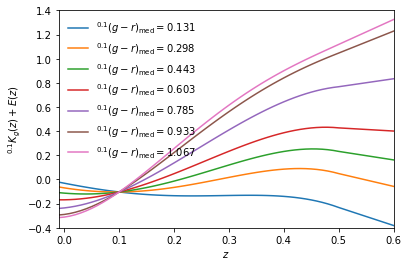

In [6]:
'''
Introduce K-correction work here.

The following cell of code is attributed to Alex Smith at Durham.
'''

class GAMA_KCorrection(object):
    
    def __init__(self, k_corr_file, z0=0.1, kind="linear"):

        """
        Colour-dependent polynomial fit to the GAMA K-correction (Fig. 13 of Smith+17), 
        used to convert between SDSS r-band Petrosian apparent magnitudes, and rest 
        frame absolute manigutues at z_ref = 0.1
        
        Args:
            k_corr_file: file of polynomial coefficients for each colour bin
            z0: reference redshift. Default value is z0=0.1
            kind: type of interpolation between colour bins,
                  e.g. "linear", "cubic". Default is "linear"
        """
        
        # read file of parameters of polynomial fit to k-correction
        # polynomial k-correction is of the form
        # A*(z-z0)^4 + B*(z-z0)^3 + C*(z-z0)^2 + D*(z-z0) + E 
        col_min, col_max, A, B, C, D, E, col_med = \
            np.loadtxt(k_corr_file, unpack=True)
    
        self.z0 = z0              # reference redshift
        self.nbins = len(col_min) # number of colour bins in file
        
        self.colour_min = np.min(col_med)
        self.colour_max = np.max(col_med)
        self.colour_med = col_med

        # functions for interpolating polynomial coefficients
        self.__A_interpolator = self.__initialize_parameter_interpolator(A, col_med, kind=kind)
        self.__B_interpolator = self.__initialize_parameter_interpolator(B, col_med, kind=kind)
        self.__C_interpolator = self.__initialize_parameter_interpolator(C, col_med, kind=kind)
        self.__D_interpolator = self.__initialize_parameter_interpolator(D, col_med, kind=kind)
        self.__E = E[0]

        # Linear extrapolation for z>0.5
        self.__X_interpolator = lambda x: None
        self.__Y_interpolator = lambda x: None
        self.__X_interpolator, self.__Y_interpolator = self.__initialize_line_interpolators() 

   
    def __initialize_parameter_interpolator(self, parameter, median_colour, kind="linear"):
        # returns function for interpolating polynomial coefficients, as a function of colour
        return interp1d(median_colour, parameter, kind=kind, fill_value="extrapolate")

    
    def __initialize_line_interpolators(self):
        # linear coefficients for z>0.5
        X = np.zeros(self.nbins)
        Y = np.zeros(self.nbins)
        
        # find X, Y at each colour
        redshift = np.array([0.48,0.5])
        arr_ones = np.ones(len(redshift))
        for i in range(self.nbins):
            if i <= 3:
                Q0 = 2.12
            else:
                Q0 = 0.8
            
            k = self.k(redshift, arr_ones*self.colour_med[i]) - Q0*(redshift-self.z0)
            X[i] = (k[1]-k[0]) / (redshift[1]-redshift[0])
            Y[i] = k[0] - X[i]*redshift[0]
        
        X_interpolator = interp1d(self.colour_med, X, kind='linear', fill_value="extrapolate")
        Y_interpolator = interp1d(self.colour_med, Y, kind='linear', fill_value="extrapolate")
        
        return X_interpolator, Y_interpolator


    def __A(self, colour):
        # coefficient of the z**4 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__A_interpolator(colour_clipped)

    def __B(self, colour):
        # coefficient of the z**3 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__B_interpolator(colour_clipped)

    def __C(self, colour):
        # coefficient of the z**2 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__C_interpolator(colour_clipped)

    def __D(self, colour):
        # coefficient of the z**1 term
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__D_interpolator(colour_clipped)

    def __X(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__X_interpolator(colour_clipped)

    def __Y(self, colour):
        colour_clipped = np.clip(colour, self.colour_min, self.colour_max)
        return self.__Y_interpolator(colour_clipped)


    def k(self, redshift, colour):
        """
        Polynomial fit to the GAMA K-correction for z<0.5
        The K-correction is extrapolated linearly for z>0.5

        Args:
            redshift: array of redshifts
            colour:   array of ^0.1(g-r) colour
        Returns:
            array of K-corrections
        """
        K = np.zeros(len(redshift))
        idx = redshift <= 0.5
        
        K[idx] = self.__A(colour[idx])*(redshift[idx]-self.z0)**4 + \
                 self.__B(colour[idx])*(redshift[idx]-self.z0)**3 + \
                 self.__C(colour[idx])*(redshift[idx]-self.z0)**2 + \
                 self.__D(colour[idx])*(redshift[idx]-self.z0) + self.__E 

        idx = redshift > 0.5
        
        K[idx] = self.__X(colour[idx])*redshift[idx] + self.__Y(colour[idx])
        
        if (colour[0] > 0.76):
            Q0 = 0.80
        else:
            Q0 = 2.12

        return K + Q0*(redshift-self.z0)

def test_plots():

    kcorr_r = GAMA_KCorrection("k_corr_rband_z01.mpeg")
    kcorr_g = GAMA_KCorrection("k_corr_gband_z01.mpeg")

    z = np.arange(-0.01,0.601,0.01)
    cols = 0.130634, 0.298124, 0.443336, 0.603434, 0.784644, 0.933226, 1.06731
    
    # make r-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_r.k(z, col)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_r(z)+E(z)$")
    plt.xlim(0,0.6)
    plt.ylim(-0.6,1)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()

    # make g-band k-correction plot
    for c in cols:
        col = np.ones(len(z)) * c
        k = kcorr_g.k(z, col)
        plt.plot(z, k, label=r"$^{0.1}(g-r)_\mathrm{med}=%.3f$"%c)

    plt.xlabel(r"$z$")
    plt.ylabel(r"$^{0.1}K_g(z)+E(z)$")
    plt.xlim(-0.01,0.6)
    plt.ylim(-0.4,1.4)
    plt.legend(loc="upper left").draw_frame(False)
    plt.show()
        
if __name__ == "__main__":
    test_plots()
    

gama_kcorr_r = GAMA_KCorrection("k_corr_rband_z01.mpeg")
gama_kcorr_g = GAMA_KCorrection("k_corr_gband_z01.mpeg")

In [7]:
def colour_observer_func(colour_rest, colour_obs, z):
    '''
    Returns the difference between the colour from the function and the 
    actual observer-frame colour.
    
    Input:
           colour_rest = the rest-frame g-r colour of the galaxy.    [int, float, array]
           colour_obs = the observer-frame g-r colour of the galaxy. [int, float, array]
           z = the redshift of the galaxy.                           [int, float, array]
    '''
    #print('colour_observer_func')
    
    colour_observer_func = colour_observer(colour_rest, z)
    #print(colour_observer_func)
    #print(colour_obs)
    return colour_observer_func - colour_obs

def k_corr_data(data, params=None):
    '''
    This function finds the rest-frame colour of galaxies using Brent's method.
    From this, the K-corrections in the r and g bands are calculated.
    Input:
        data: the relevant dataset   [Astropy Table]
        params (optional): will generate an alternative 
    '''
    
    if params == None:
        data['G-R_REST'] = 0.0

        for i in range(len(data)):
            colour_obs_holder = data['G-R_OBS'][i]
            z_holder = data['Z'][i]

            try:
                root = optimize.brentq(colour_observer_func, -2, 5, args=(colour_obs_holder, z_holder))        
                data['G-R_REST'][i] = root

            except:
                pass
        
        data['K_R'] = gama_kcorr_r.k(data['Z'], data['G-R_REST'])
        data['K_G'] = gama_kcorr_g.k(data['Z'], data['G-R_REST'])
    
    else:
        data['K_R'] = params[0]*data['Z']**4 + params[1]*data['Z']**3 + params[2]*data['Z']**2 + params[3]*data['Z']**1 + params[4]*data['Z']**0

In [8]:
def mw_xtinct(ebv, band):
    '''
    A function to account for MW dust attenuation on observed fluxes. Taken from
    https://github.com/michaelJwilson/bgs-cmxsv/blob/main/py/bgs-cmxsv/mw_xtinct.py
    
    Input:
        EBV  : Extinction coefficient = (B-V)_obs - (B-V)_int     [Float]
        band : The relevant colour band (G, R, i, Z, Y)           [String] 
    '''
    
    #coeffs = {'G': 3.214, 'R': 2.165, 'i': 1.592, 'Z': 1.211, 'Y': 1.064}
    #Ab     = coeffs[band] * desiutil.dust.mwdust_transmission(, 'R', 'N')
    #return  10.**(-Ab / 2.5) 
    
    return desiutil.dust.mwdust_transmission(ebv, 'R', 'N')

def g_r_obs_func(data):
    '''
    Calculates observer-frame colour for a table given FLUX_R, FLUX_G and EBV.
    
    Input:
        data : the relevant dataset (such as deep_bright)         [Astropy Table]
    '''
    Fg = data['FLUX_G'] / mw_xtinct(data['EBV'], 'G')
    Fr = data['FLUX_R'] / mw_xtinct(data['EBV'], 'R')

    data['G-R_OBS'] = -2.5*np.log10(Fg/Fr)

In [9]:
filename = 'bright_v0.0.fits'
hdul = astropy.io.fits.open(filename)

with fits.open(filename) as hdu:
    data = Table(hdu[1].data)

Text(0.5, 1.0, 'GAMA Fields')

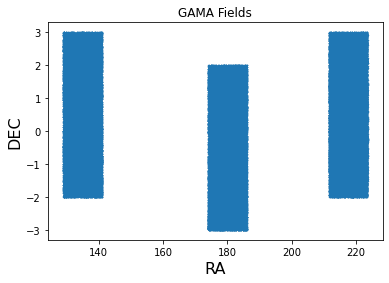

In [10]:
plt.scatter(data['RA'], data['DEC'], s=0.25)
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)
plt.title('GAMA Fields')

In [11]:
try:
    data.rename_column('RA', 'TARGET_RA')
    data.rename_column('DEC', 'TARGET_DEC')
    data.rename_column('ZGAMA', 'Z')
except:
    pass

C:\Users\sgmoo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


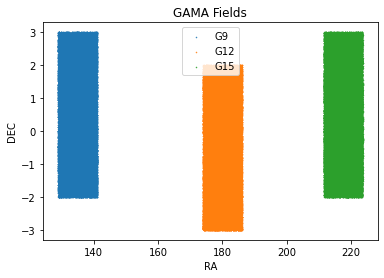

In [12]:
data['GFIELD'] = 0

for i in range(len(data)):
    if data['TARGET_RA'][i] < 150:
        data['GFIELD'][i] = 9
    elif (data['TARGET_RA'][i] > 150) and (data['TARGET_RA'][i] < 200):
        data['GFIELD'][i] = 12
    else:
        data['GFIELD'][i] = 15

G9 = data[data['GFIELD'] == 9]
G12 = data[data['GFIELD'] == 12]
G15 = data[data['GFIELD'] == 15]

plt.scatter(G9['TARGET_RA'], G9['TARGET_DEC'], s=0.25, label='G9')
plt.scatter(G12['TARGET_RA'], G12['TARGET_DEC'], s=0.25, label='G12')
plt.scatter(G15['TARGET_RA'], G15['TARGET_DEC'], s=0.25, label='G15')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('GAMA Fields')
plt.legend()
plt.show()

In [13]:
G9_ra_min, G9_ra_max = min(G9['TARGET_RA']), max(G9['TARGET_RA'])
G9_dec_min, G9_dec_max = min(G9['TARGET_DEC']), max(G9['TARGET_DEC'])

G12_ra_min, G12_ra_max = min(G12['TARGET_RA']), max(G12['TARGET_RA'])
G12_dec_min, G12_dec_max = min(G12['TARGET_DEC']), max(G12['TARGET_DEC'])

G15_ra_min, G15_ra_max = min(G15['TARGET_RA']), max(G15['TARGET_RA'])
G15_dec_min, G15_dec_max = min(G15['TARGET_DEC']), max(G15['TARGET_DEC'])

print(G9_ra_min, G9_ra_max)
print(G9_dec_min, G9_dec_max)
print(G12_ra_min, G12_ra_max)
print(G12_dec_min, G12_dec_max)
print(G15_ra_min, G15_ra_max)
print(G15_dec_min, G15_dec_max)

d_ra_min_array = [G9_ra_min, G12_ra_min, G15_ra_min]
d_ra_max_array = [G9_ra_max, G12_ra_max, G15_ra_max]
d_dec_min_array = [G9_dec_min, G12_dec_min, G15_dec_min]
d_dec_max_array = [G9_dec_max, G12_dec_max, G15_dec_max]

129.00007574 140.99960692
-1.99999154 2.99999935
174.00046468 185.99943836
-2.99990056 1.99991296
211.50030624 223.49985581
-1.99995686 2.99995944


Text(0, 0.5, 'r_SDSS')

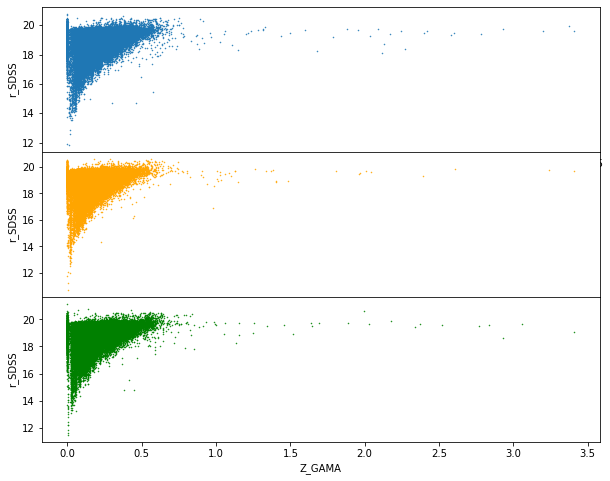

In [14]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['RMAG_DRED_SDSS'], s=0.25)
ax[1].scatter(G12['Z'], G12['RMAG_DRED_SDSS'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['RMAG_DRED_SDSS'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_SDSS')
ax[1].set_ylabel('r_SDSS')
ax[2].set_ylabel('r_SDSS')

Text(0, 0.5, 'r_petro')

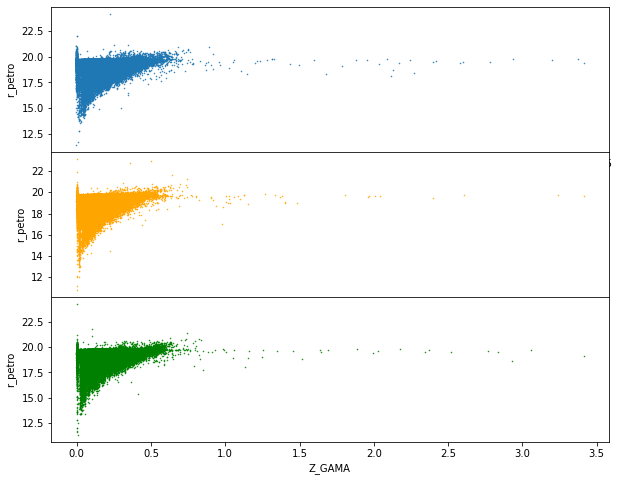

In [15]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['R_PETRO'], s=0.25)
ax[1].scatter(G12['Z'], G12['R_PETRO'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['R_PETRO'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_petro')
ax[1].set_ylabel('r_petro')
ax[2].set_ylabel('r_petro')

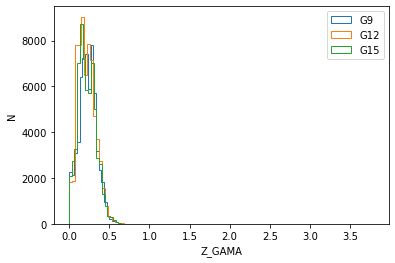

In [16]:
bins = 100
plt.hist(G9['Z'], bins=bins, histtype='step', label='G9')
plt.hist(G12['Z'], bins=bins, histtype='step', label='G12')
plt.hist(G15['Z'], bins=bins, histtype='step', label='G15')
plt.xlabel('Z_GAMA')
plt.ylabel('N')
plt.legend()
plt.show()

In [17]:
'''
Next selection cuts
'''

print(len(data))
data = data[data['SURVEY_CLASS'] >= 4]
data = data[data['Z'] > 0.001]
data = data[data['Z'] < 0.6]
data = data[data['R_PETRO'] < mag_limit]
print(len(data))

G9 = data
G9 = G9[G9['TARGET_RA'] < 150]
G9_ra_min, G9_ra_max = min(G9['TARGET_RA']), max(G9['TARGET_RA'])
G9_dec_min, G9_dec_max = min(G9['TARGET_DEC']), max(G9['TARGET_DEC'])

G12 = data
G12 = G12[G12['TARGET_RA'] > 150]
G12 = G12[G12['TARGET_RA'] < 200]
G12_ra_min, G12_ra_max = min(G12['TARGET_RA']), max(G12['TARGET_RA'])
G12_dec_min, G12_dec_max = min(G12['TARGET_DEC']), max(G12['TARGET_DEC'])

G15 = data
G15 = G15[G15['TARGET_RA'] > 200]
G15_ra_min, G15_ra_max = min(G15['TARGET_RA']), max(G15['TARGET_RA'])
G15_dec_min, G15_dec_max = min(G15['TARGET_DEC']), max(G15['TARGET_DEC'])

d_ra_min_array = [G9_ra_min, G12_ra_min, G15_ra_min]
d_ra_max_array = [G9_ra_max, G12_ra_max, G15_ra_max]
d_dec_min_array = [G9_dec_min, G12_dec_min, G15_dec_min]
d_dec_max_array = [G9_dec_max, G12_dec_max, G15_dec_max]

188032
182291


Text(0.5, 1.0, 'GAMA Fields')

C:\Users\sgmoo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


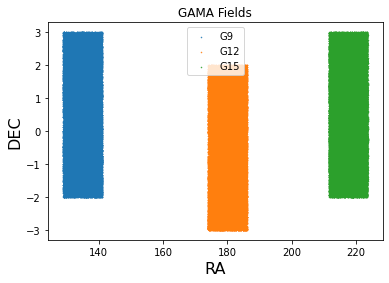

In [18]:
plt.scatter(G9['TARGET_RA'], G9['TARGET_DEC'], s=0.25, label='G9')
plt.scatter(G12['TARGET_RA'], G12['TARGET_DEC'], s=0.25, label='G12')
plt.scatter(G15['TARGET_RA'], G15['TARGET_DEC'], s=0.25, label='G15')
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16)
plt.legend()
plt.title('GAMA Fields')

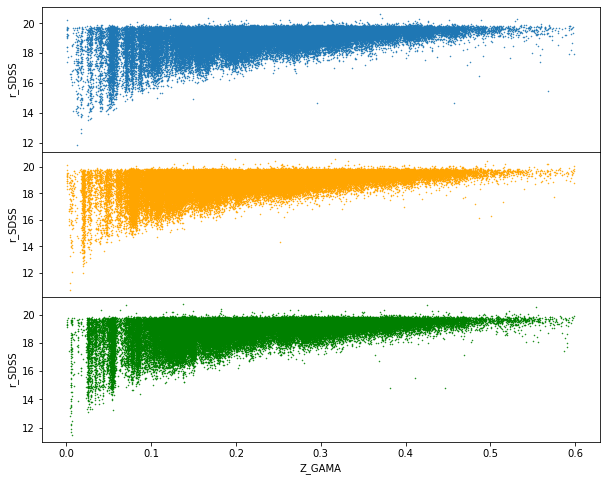

In [19]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['RMAG_DRED_SDSS'], s=0.25)
ax[1].scatter(G12['Z'], G12['RMAG_DRED_SDSS'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['RMAG_DRED_SDSS'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_SDSS')
ax[1].set_ylabel('r_SDSS')
ax[2].set_ylabel('r_SDSS')
plt.show()

Text(0, 0.5, 'r_petro')

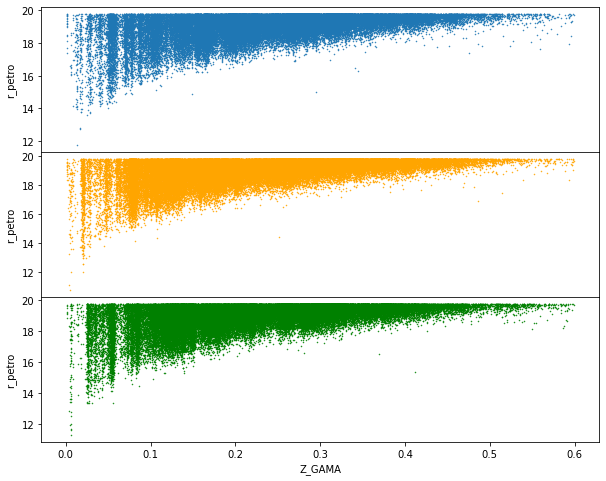

In [20]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].scatter(G9['Z'], G9['R_PETRO'], s=0.25)
ax[1].scatter(G12['Z'], G12['R_PETRO'], c='orange', s=0.25)
ax[2].scatter(G15['Z'], G15['R_PETRO'], c='green', s=0.25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Z_GAMA')
ax[0].set_ylabel('r_petro')
ax[1].set_ylabel('r_petro')
ax[2].set_ylabel('r_petro')

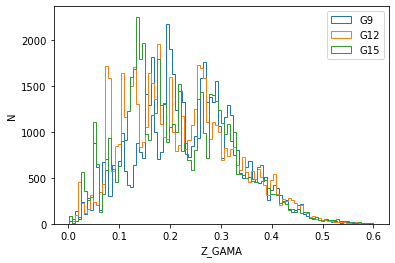

In [21]:
bins = 100
plt.hist(G9['Z'], bins=bins, histtype='step', label='G9')
plt.hist(G12['Z'], bins=bins, histtype='step', label='G12')
plt.hist(G15['Z'], bins=bins, histtype='step', label='G15')
plt.xlabel('Z_GAMA')
plt.ylabel('N')
plt.legend()
plt.show()

Text(0, 0.5, 'r_petro')

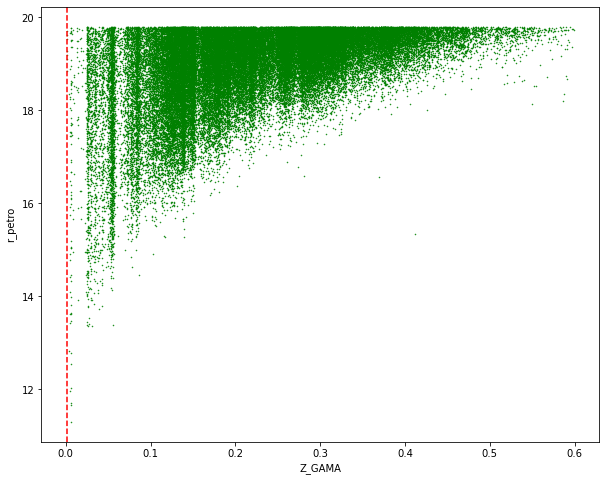

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.scatter(G15['Z'], G15['R_PETRO'], c='green', s=0.25)
plt.axvline(0.001, color='r', ls='--', label='cz=300km/s')
plt.xlabel('Z_GAMA')
plt.ylabel('r_petro')

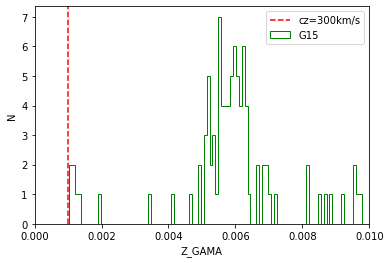

In [23]:
bins = 100
plt.hist(G15[G15['Z'] < 0.01]['Z'], bins=bins, histtype='step', label='G15', color='green')
plt.axvline(0.001, color='r', ls='--', label='cz=300km/s')
plt.xlabel('Z_GAMA')
plt.ylabel('N')
plt.xlim(0, 0.01)
plt.legend()
plt.show()

In [2]:
plt.scatter(data['RMAG_DRED_SDSS'], data['RMAG_DRED_SDSS'] - data['R_PETRO'], s=0.25)
plt.axhline(0, color='black', ls='--')
plt.xlabel(r'$r_{SDSS}$')
plt.ylabel(r'$r_{SDSS} - r_{petro}$')
plt.show()

plt.scatter(data['R_PETRO'], data['RMAG_DRED_SDSS'] - data['R_PETRO'], s=0.25)
plt.axhline(0, color='black', ls='--')
plt.xlabel(r'$r_{petro}$')
plt.ylabel(r'$r_{SDSS} - r_{petro}$')
plt.show()

NameError: name 'plt' is not defined

In [508]:

try:
    data['FLUX_G_MW'] = data['FLUX_G'] / mw_xtinct(data['EBV'], 'G')
    data['FLUX_R_MW'] = data['FLUX_R'] / mw_xtinct(data['EBV'], 'R')
    #data['FLUX_Z_MW'] = data['FLUX_Z'] / mw_xtinct(data['EBV'], 'Z')
    data['FIBERFLUX_G_MW'] = data['FIBERFLUX_G'] / mw_xtinct(data['EBV'], 'G')
    data['FIBERFLUX_R_MW'] = data['FIBERFLUX_R'] / mw_xtinct(data['EBV'], 'R')
    #data['FIBERFLUX_Z_MW'] = data['FIBERFLUX_Z'] / mw_xtinct(data['EBV'], 'Z')

    g_r_obs_func(data)
    k_corr_data(data, params=None)
except:
    print('Entered Except Clause.')
    data['G-R_OBS'] = data['GMAG_DRED_SDSS'] - data['RMAG_DRED_SDSS']
    k_corr_data(data, params=[-6.299, 14.76, -7.473, 1.847, -0.006801])
    #k_corr_data(data, params=None)


Entered Except Clause.


In [509]:
gr_array = [-1, (0.158+0.298)/2, (0.298+0.419)/2, (0.419+0.553)/2, (0.553+0.708)/2, (0.708+0.796)/2, (0.796+0.960)/2, 5]

colour_array = [0.158, 0.298, 0.419, 0.553, 0.708, 0.796, 0.960]

params_array = [[-31.36, 38.63, -14.79, 1.427, 0.001301],
                [-17.77, 25.50, -10.79, 1.366, 0.006235],
                [-12.94, 21.44, -9.826, 1.683, -0.001972],
                [-6.299, 14.76, -7.473, 1.847, -0.006801],
                [9.017, -1.390, -0.9145, 1.376, -0.004724],
                [14.78, -6.592, 0.9443, 1.357, -0.005131],
                [15.09, -5.730, -0.2097, 1.859, -0.01250]]
data_array = []

data['G-R_REST'] = 0.0
for i in tqdm(range(len(data))):
    z = data['Z'][i]
    colour_obs = data['G-R_OBS'][i]
    data['G-R_REST'][i] = colour_rest_func(colour_obs, z)

100%|██████████| 182291/182291 [17:42<00:00, 171.58it/s]


In [510]:


#data_t = data[data['Z'] <= 0.26]
for i in range(len(gr_array)-1):
    data_t1 = data
    data_t1 = data_t1[data_t1['G-R_REST'] > gr_array[i]]
    data_t1 = data_t1[data_t1['G-R_REST'] < gr_array[i+1]]
    data_t1['G-R_OBS'] = data_t1['GMAG_DRED_SDSS'] - data_t1['RMAG_DRED_SDSS']
    data_t1['G-R_REST_REAL'] = data_t1['G-R_REST']
    #data_t1['G-R_REST'] = colour_array[i]
    k_corr_data(data_t1, params=params_array[i])
    params = params_array[i]
    #data_t1['K_R'] = params[0]*data_t1['Z']**4 + params[1]*data_t1['Z']**3 + params[2]*data_t1['Z']**2 + params[3]*data_t1['Z']**1 + params[4]*data_t1['Z']**0
    data_array.append(data_t1)

data = data_array[0]
for i in range(1, len(data_array)):
    data = vstack([data, data_array[i]])

(-1.0, 5.0)

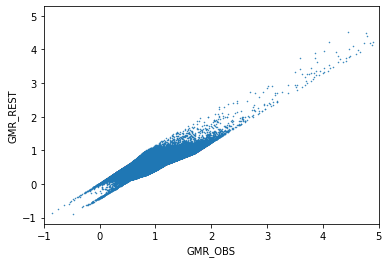

In [512]:
plt.scatter(data['G-R_OBS'], data['G-R_REST'], s=0.25)
plt.xlabel('GMR_OBS')
plt.ylabel('GMR_REST')
plt.xlim(-1, 5)

In [513]:
def app_mag_calc(data):
    #data['MW_CORRECTION_R'] = mw_xtinct(data['EBV'], band='R')
    try:
        data['MODEL_MAG'] = 22.5 - 2.5*np.log10(data['FLUX_R_MW']) #/ data['MW_CORRECTION_R'])
        data['MODEL_FIBRE_MAG'] = 22.5 - 2.5*np.log10(data['FIBERFLUX_R_MW']) #/ data['MW_CORRECTION_R'])
    except:
        # use Petrosian magnitude
        data['MODEL_MAG'] = data['R_PETRO']
        data['MODEL_FIBRE_MAG'] = data['FIBERMAG_R']
        
def abs_mag_calc(data):
    lum_dist_list = cosmo.luminosity_distance(data['Z']).value
    abs_mag_list = data['MODEL_MAG'] - (5 * np.log10(lum_dist_list)) - 25
    data['M_R'] = abs_mag_list - data['K_R']

In [514]:
app_mag_calc(data)
abs_mag_calc(data)

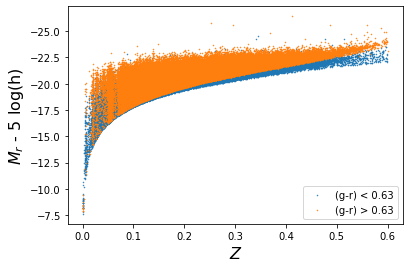

In [515]:
plt.scatter(data[data['G-R_REST']<0.63]['Z'], data[data['G-R_REST']<0.63]['M_R'], s=0.25, label='(g-r) < 0.63')
plt.scatter(data[data['G-R_REST']>0.63]['Z'], data[data['G-R_REST']>0.63]['M_R'], s=0.25, label='(g-r) > 0.63')
plt.xlabel(r'$Z$', fontsize=16)
plt.ylabel(r'$M_r$ - 5 log(h)', fontsize=16)
plt.gca().invert_yaxis()
plt.legend()

In [518]:
print(len(data), min(data['Z']), max(data['Z']))

182258 0.00101 0.59987


In [519]:
#num_of_tiles = len(np.unique(data['TILEID']))
#dia = 3 # diameter of tile, double check this
#deg_sq = (dia/2)**2 *np.pi * num_of_tiles
deg_sq = 12*5*3

sky_fraction = deg_sq / 41253 # total sq deg. on sky

xspace = np.linspace(-22.5, -14.99, 100000) # for plotting Schechter
xedges = np.arange(-23, -14.99, 0.5) # for plotting LF

In [520]:
def schechter(M, Mstar, alpha, phistar):
    return 0.4*np.log(10)*phistar * (10**(0.4*(Mstar-M)))**(alpha+1) * np.exp(-10**(0.4*(Mstar-M)))

def log_schechter(M, Mstar, alpha, phistar):
    return np.log10(0.4*np.log(10)*phistar * (10**(0.4*(Mstar-M)))**(alpha+1) * np.exp(-10**(0.4*(Mstar-M))))

In [521]:
def diff_func(z, abs_mag, mag_limit, colour_rest, params=None):

    lum_dist = cosmo.luminosity_distance(z).value
    
    if params==None:
        if isinstance(colour_rest, int) or isinstance(colour_rest, float):
            colour_rest = np.array([colour_rest])
        else:
            colour_rest = np.array(colour_rest)

        if isinstance(z, int) or isinstance(z, float):
            z = np.array([z])
        else:
            z = np.array(z)
        
        #app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + gama_kcorr_r.k_shift(z, colour_rest)
        if z_shift == False:
            app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + gama_kcorr_r.k(z, colour_rest) 
        else:
            app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + gama_kcorr_r.k(z, colour_rest) - gama_kcorr_r.k(np.zeros(len(colour_rest)), colour_rest) 

    else:
        K_r = params[0]*z**4 + params[1]*z**3 + params[2]*z**2 + params[3]*z**1 + params[4]*z**0 
        app_mag = abs_mag + (5 * np.log10(lum_dist)) + 25 + K_r
    
    return app_mag - mag_limit
    
    
def vmax_brent(data, lower_z, upper_z, mag_limit, params=None):
    abs_mag = data['M_R']
    colour_rest = data['G-R_REST']

    #min_z = 0
    #max_z = 0.6
    #print(min_z, max_z)
    
    root = scipy.optimize.brentq(diff_func, min_z, max_z, args=(abs_mag, mag_limit, colour_rest))
    
    #z_lim_min = np.min([root, lower_z])
    z_lim_min = np.min([lower_z])
    z_lim_max = np.min([root, upper_z])
    #print('z_lim_max', z_lim_max)
    vol = h**3 * (cosmo.comoving_volume(z_lim_max).value - cosmo.comoving_volume(z_lim_min).value)
    return vol #, root

In [522]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 
# quick test of function
i = 0
data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)

In [526]:
'''
add correction here?
'''

z_shift = True

In [527]:
data['M_R_0.1'] = data['M_R']
data['M_R'] = data['M_R_0.1'] + gama_kcorr_r.k(np.zeros(len(data)), data['G-R_REST'])

In [528]:
#data['G-R_REST_0.1'] = data['G-R_REST']
#data['G-R_REST'] = data['G-R_REST_0.1'] + gama_kcorr_g.k(np.zeros(len(data)), data['G-R_REST_0.1']) - gama_kcorr_r.k(np.zeros(len(data)), data['G-R_REST_0.1'])

In [529]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 
# quick test of function
i = 0
data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)

In [530]:
min_z = min(data['Z'])
max_z = max(data['Z'])

data['V'] = 0.0
data['VMAX'] = 0.0 

pass_array = []
roots = []
for i in tqdm(range(len(data))):
    try:        
        data['V'][i] = h**3 * (cosmo.comoving_volume(data['Z'][i]).value - cosmo.comoving_volume(min_z).value)
        data['VMAX'][i] = vmax_brent(data[i], min_z, max_z, mag_limit, params=None)
    except:
        pass_array.append(i)

print(len(data[data['V'] > data['VMAX']]))

100%|██████████| 182258/182258 [31:02<00:00, 97.84it/s] 


3765


0


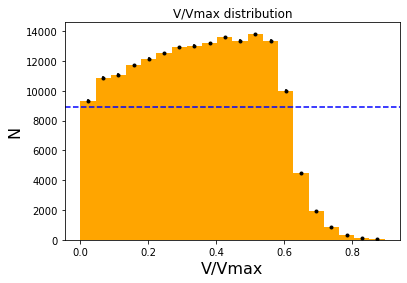

In [533]:
print(len(data[data['VMAX'] == 0]))
data = data[data['VMAX'] != 0]
data['V_VMAX'] = data['V']/data['VMAX']

n, bins, _ = plt.hist(data['V_VMAX'], bins=20, color='orange')
mid = 0.5*(bins[1:] + bins[:-1])
plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
plt.axhline(np.mean(n), ls='--', color='b')
plt.xlabel('V/Vmax',fontsize=16)
plt.ylabel('N', fontsize=16)
#plt.xlim(0, 1)
plt.title('V/Vmax distribution')
plt.show()

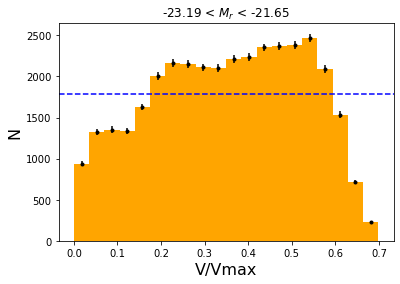

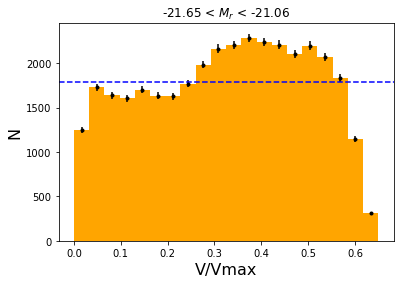

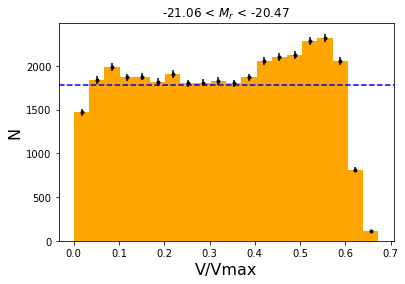

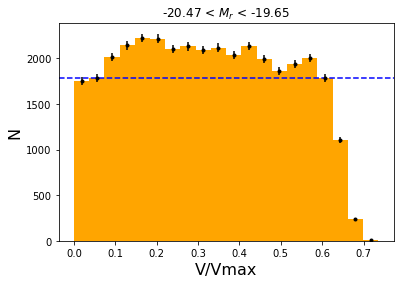

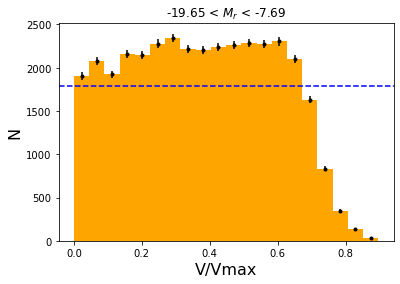

In [532]:
Mr_array = stats.mstats.mquantiles(data['M_R'][~np.isnan(data['M_R'])], np.arange(0, 1.0001, 0.2))
pass_array = []

for i in range(len(Mr_array)-1):

    data_Mr = data
    data_Mr = data_Mr[data_Mr['M_R'] > Mr_array[i]]
    data_Mr = data_Mr[data_Mr['M_R'] < Mr_array[i+1]]
    
    n, bins, _ = plt.hist(data_Mr['V_VMAX'], bins=20, color='orange')
    mid = 0.5*(bins[1:] + bins[:-1])
    plt.errorbar(mid, n, yerr=np.sqrt(n), fmt='.k')
    plt.axhline(np.mean(n), ls='--', color='b')
    plt.xlabel('V/Vmax',fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.title(r'{} < $M_r$ < {}'.format(round(Mr_array[i],2), round(Mr_array[i+1], 2)))
    plt.show()

In [476]:
#ascii.write(data, 'new_GAMA_dataset_ke_06122021_wrongQ.csv', format='csv', fast_writer=False, overwrite=True)

In [69]:
data_t = data
data_t = data_t[data_t['Z'] < 0.26]
print(len(data_t))

#gr_array = stats.mstats.mquantiles(data_t['G-R_REST'][~np.isnan(data_t['G-R_REST'])], np.arange(0, 1.0001,1/7))
gr_array = np.arange(min(data_t['G-R_REST']), max(data['G-R_REST']), (max(data['G-R_REST'])-min(data_t['G-R_REST']))/7)

for i in range(len(gr_array)-1):
    data_t1 = data_t
    data_t1 = data_t1[data_t1['G-R_REST'] > gr_array[i]]
    data_t1 = data_t1[data_t1['G-R_REST'] < gr_array[i+1]]
    print(np.median(data_t1['G-R_REST']))

114236
-0.4565581210607157
0.5157627145142836
0.9113795619810494
2.0308876872262425
3.342292033768846
4.402417743803299


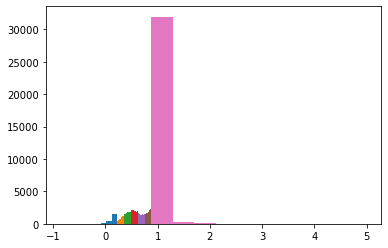

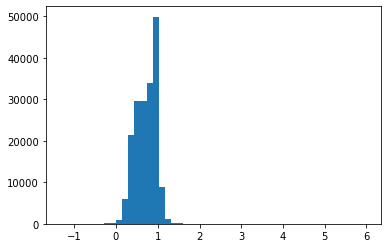

In [75]:
gr_array = [-1, (0.158+0.298)/2, (0.298+0.419)/2, (0.419+0.553)/2, (0.553+0.708)/2, (0.708+0.796)/2, (0.796+0.960)/2, 5]

data_t = data[data['Z'] <= 0.26]
for i in range(len(gr_array)-1):
    data_t1 = data_t
    data_t1 = data_t1[data_t1['G-R_REST'] > gr_array[i]]
    data_t1 = data_t1[data_t1['G-R_REST'] < gr_array[i+1]]
    plt.hist(data_t1['G-R_REST'])
plt.show()

plt.hist(data['G-R_REST'], bins=50)
plt.show()

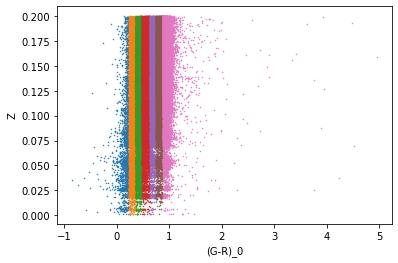

In [50]:
gr_array = [-1, (0.158+0.298)/2, (0.298+0.419)/2, (0.419+0.553)/2, (0.553+0.708)/2, (0.708+0.796)/2, (0.796+0.960)/2, 5]

data_t = data[data['Z'] <= 0.26]
for i in range(len(gr_array)-1):
    data_t1 = data_t
    data_t1 = data_t1[data_t1['G-R_REST'] > gr_array[i]]
    data_t1 = data_t1[data_t1['G-R_REST'] < gr_array[i+1]]
    plt.scatter(data_t1['G-R_REST'], data_t1['Z'], s=0.25)
plt.xlabel('(G-R)_0')
plt.ylabel('Z')
#plt.legend()
plt.show()

In [235]:
data = ascii.read('new_GAMA_dataset_ke_06122021.csv', format='csv')

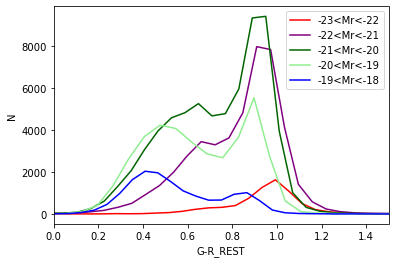

In [236]:
Mr_array = [-23, -22, -21, -20, -19, -18]
colours = ['red', 'purple', 'darkgreen', 'lightgreen', 'blue']
for i in range(len(Mr_array)-1):
    data_t = data
    data_t = data_t[data_t['M_R'] > Mr_array[i]]
    data_t = data_t[data_t['M_R'] < Mr_array[i+1]]
    hist, bin_edges = np.histogram(data_t['G-R_REST'], bins=100)
    centres = (bin_edges[1:]+bin_edges[:-1])/2
    plt.plot(centres, hist, color=colours[i], label='{}<Mr<{}'.format(Mr_array[i], Mr_array[i+1]))
plt.xlabel('G-R_REST')
plt.ylabel('N')
plt.xlim(0, 1.5)
plt.legend()
plt.show()

Text(0, 0.5, 'GMR_REST')

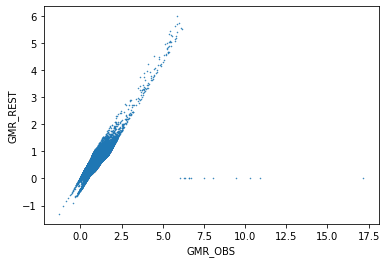

In [237]:
plt.scatter(data['G-R_OBS'], data['G-R_REST'], s=0.25)
plt.xlabel('GMR_OBS')
plt.ylabel('GMR_REST')